# Imports and definitions

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../source")))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils.custom_classes.GarbageClassifier import GarbageClassifier
from utils.custom_classes.GarbageDataModule import GarbageDataModule
from utils import config as cfg

In [47]:
def plot_top_misclassified(df, y_true, y_pred, y_proba, dataset_path, N=10, filename = None):
    """
    Plot the top N misclassified examples with the lowest confidence in the true class.
    
    df: pandas DataFrame with 'filename' and 'label' columns
    y_true: array-like of true labels (ints or strings)
    y_pred: array-like of predicted labels (ints or strings)
    y_proba: array-like of predicted probabilities (shape: n_samples x n_classes)
    dataset_path: path to dataset root folder
    N: number of misclassified samples to show
    """
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle case: y_true are integers vs strings
    if np.issubdtype(y_true.dtype, np.integer):
        true_indices = y_true
        classes = sorted(df['label'].unique())  # class names for plotting
    else:
        classes = sorted(np.unique(y_true))
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        true_indices = np.array([class_to_idx[label] for label in y_true])
    
    # Confidence in the true class
    true_confidences = y_proba[np.arange(len(y_true)), true_indices]
    
    # Find misclassified samples
    misclassified_idx = np.where(y_true != y_pred)[0]
    
    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return
    
    # Sort misclassified by confidence in true class (ascending)
    sorted_idx = misclassified_idx[np.argsort(true_confidences[misclassified_idx])]
    
    # Select top N worst
    selected_idx = sorted_idx[:N]
    
    # Plot
    plt.figure(figsize=(15, 3 * (N // 5 + 1)))
    for i, idx in enumerate(selected_idx, 1):
        row = df.iloc[idx]
        img_path = os.path.join(dataset_path, row['label'], row['filename'])

        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue
        
        try:
            print(img_path)
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error opening {img_path}: {e}")
            continue
        
        plt.subplot(int(np.ceil(N/5)), 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"True: {row['label']}\nPred: {classes[y_pred[idx]]}\nConf True Class: {true_confidences[idx]:.2f}",
            fontsize=9,
            color="red"
        )
    
    plt.tight_layout()
    if filename != None:
        plt.savefig(f"{PERFORMANCE_FIGS_PATH}{filename}.pdf", dpi = 80)
    plt.show()

In [43]:
ROOT_PATH = os.path.join("..", "data", "raw")
DATASET_PATH = os.path.join(ROOT_PATH, "sample_dataset")
PERFORMANCE_FIGS_PATH = '../reports/figures/performance/'
metadata_path = os.path.join(os.path.join(ROOT_PATH, "Garbage_Dataset_Classification"), "metadata.csv")
df = pd.read_csv(metadata_path)

In [4]:
carpeta_principal = cfg.DATASET_PATH
file_names = []

for root, dirs, files in os.walk(carpeta_principal):
    for file in files:
        file_names.append(file)  

In [20]:
df_subset = df[df['filename'].isin(file_names)].reset_index(drop = True).copy()

# Loss curves

In [6]:
with open(f"{cfg.LOSS_CURVES_PATH}metrics.json", "r") as f:
    metrics = json.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
val_accs = metrics["val_accs"]

In [7]:
print(len(train_losses), len(val_losses))

10 10


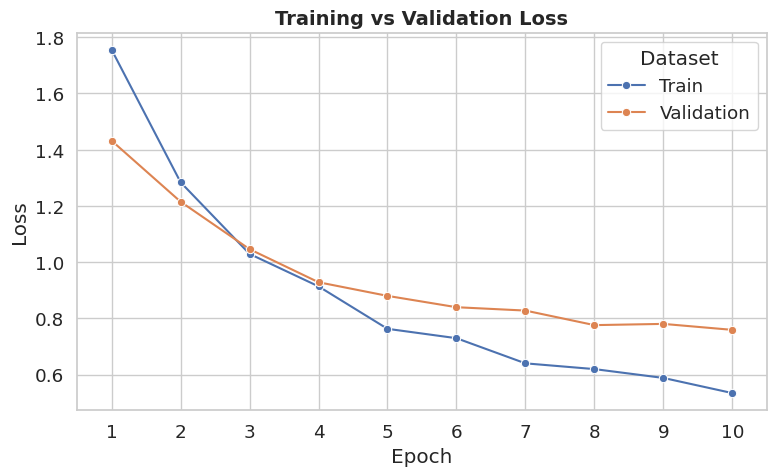

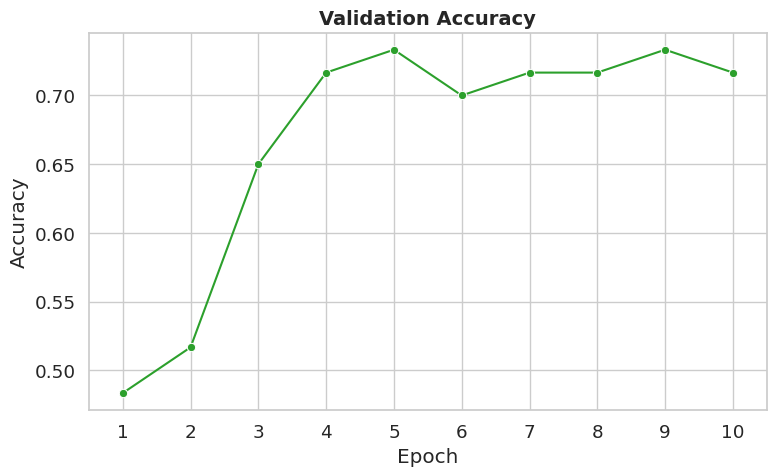

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid", font_scale=1.2)

epochs = list(range(1, len(train_losses) + 1))
df_loss = pd.DataFrame({
    "Epoch": epochs + epochs,
    "Loss": train_losses + val_losses,
    "Set": ["Train"] * len(train_losses) + ["Validation"] * len(val_losses)
})

df_acc = pd.DataFrame({
    "Epoch": epochs,
    "Accuracy": val_accs
})

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_loss, x="Epoch", y="Loss", hue="Set", marker="o")
plt.title("Training vs Validation Loss", fontsize=14, weight="bold")
plt.legend(title="Dataset")
plt.xticks(range(len(train_losses) + 1))
plt.xlim(0.5, 10.5)
plt.tight_layout()
plt.savefig(f"{PERFORMANCE_FIGS_PATH}train_vs_val_loss.pdf", dpi = 80)
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_acc, x="Epoch", y="Accuracy", marker="o", color="tab:green")
plt.title("Validation Accuracy", fontsize=14, weight="bold")
plt.xticks(range(len(train_losses) + 1))
plt.xlim(0.5, 10.5)
plt.tight_layout()
plt.savefig(f"{PERFORMANCE_FIGS_PATH}val_acc.pdf", dpi = 80)
plt.show()


# Prediction analysis

In [9]:
print(f"Loading model...")
model = GarbageClassifier.load_from_checkpoint(cfg.MODEL_PATH, num_classes = cfg.NUM_CLASSES)
print(f"Done")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

Loading model...
Done


GarbageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [10]:
data_module = GarbageDataModule(batch_size=32)
data_module.setup()

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [24]:
df_train_set = df_subset.iloc[data_module.train_idx].reset_index(drop = True).copy()
df_test_set = df_subset.iloc[data_module.test_idx].reset_index(drop = True).copy()

## Train set

In [25]:
all_preds_train = []
all_labels_train = []
all_probs_train = []

with torch.no_grad():
    for xb, yb in train_loader:
        out = model(xb)                  # logits
        preds = out.argmax(dim=1)        # classes
        probs = torch.softmax(out, dim=1)# probabilities
        all_probs_train.append(probs.cpu())
        all_preds_train.append(preds)
        all_labels_train.append(yb)

all_preds_train = torch.cat(all_preds_train)
all_labels_train = torch.cat(all_labels_train)
all_probs_train = torch.cat(all_probs_train).numpy()

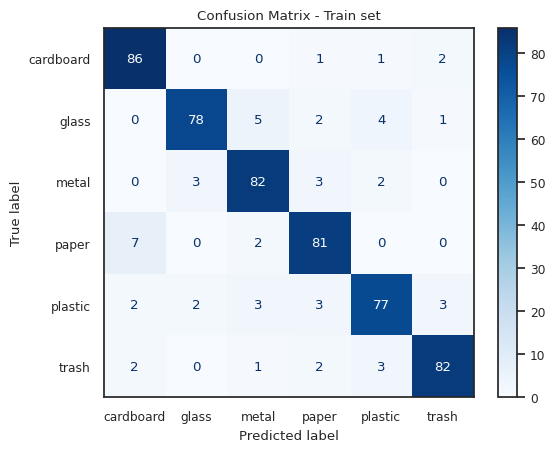

Clase 0: TP=86, FP=11, FN=4, TN=439
Clase 1: TP=78, FP=5, FN=12, TN=445
Clase 2: TP=82, FP=11, FN=8, TN=439
Clase 3: TP=81, FP=11, FN=9, TN=439
Clase 4: TP=77, FP=10, FN=13, TN=440
Clase 5: TP=82, FP=6, FN=8, TN=444


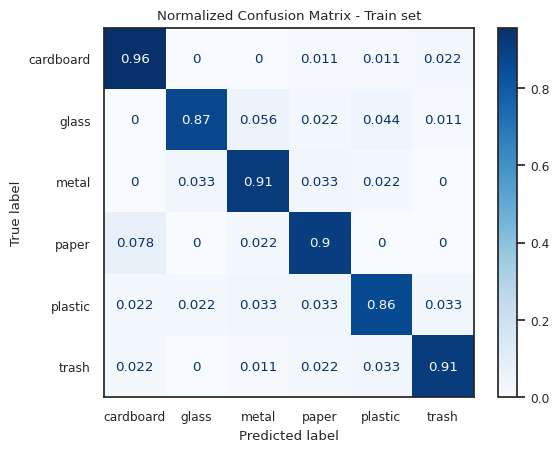

In [46]:
sns.set_theme(style="white", font_scale=0.8)

num_classes = data_module.num_classes

# ================================
# Confussion Matrix - Train set
# ================================
cm = confusion_matrix(all_labels_train, all_preds_train, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(cfg.CLASS_NAMES))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train set")
plt.savefig(f"{PERFORMANCE_FIGS_PATH}confussion_mat_train.pdf", dpi = 80)
plt.show()

# ================================
# TP, FP, FN, TN per class
# ================================
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

for i in range(num_classes):
    print(f"Clase {i}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, TN={TN[i]}")

# ================================
# Normalized Confussion Matrix - Train set
# ================================
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=(cfg.CLASS_NAMES))
disp_norm.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix - Train set")
plt.savefig(f"{PERFORMANCE_FIGS_PATH}confussion_mat_train_norm.pdf", dpi = 80)
plt.show()

../data/raw/sample_dataset/plastic/plastic_02455.jpg
../data/raw/sample_dataset/cardboard/cardboard_01391.jpg
../data/raw/sample_dataset/glass/glass_05078.jpg
../data/raw/sample_dataset/metal/metal_02028.jpg
../data/raw/sample_dataset/plastic/plastic_01602.jpg


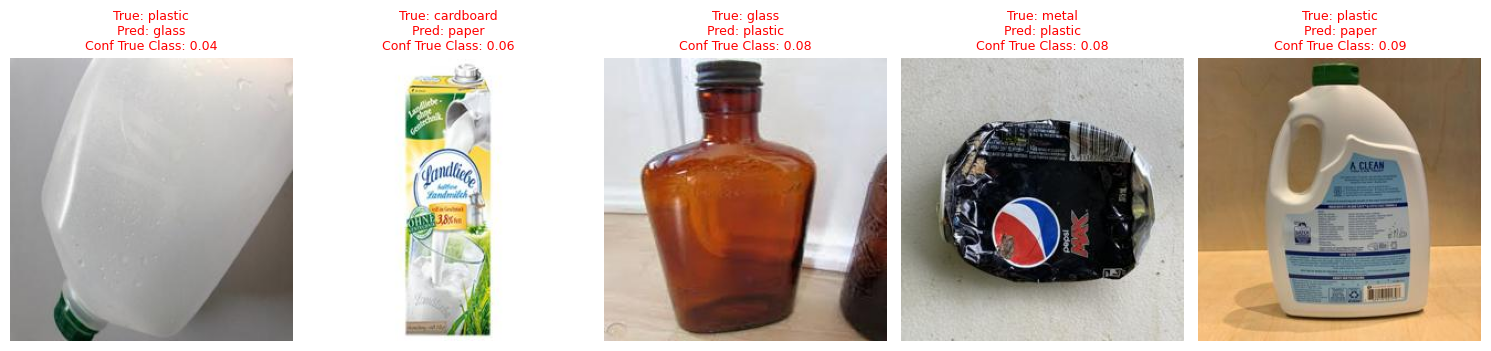

In [48]:
plot_top_misclassified(df_train_set, all_labels_train, all_preds_train, all_probs_train, DATASET_PATH, N=5, filename = "worst_classified_train_samples")

## Test set

In [33]:
all_preds_test = []
all_labels_test = []
all_probs_test = []

with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb)                  # logits
        preds = out.argmax(dim=1)        # classes
        probs = torch.softmax(out, dim=1)# probabilities
        all_probs_test.append(probs.cpu())
        all_preds_test.append(preds)
        all_labels_test.append(yb)

all_preds_test = torch.cat(all_preds_test)
all_labels_test = torch.cat(all_labels_test)
all_probs_test = torch.cat(all_probs_test).numpy()

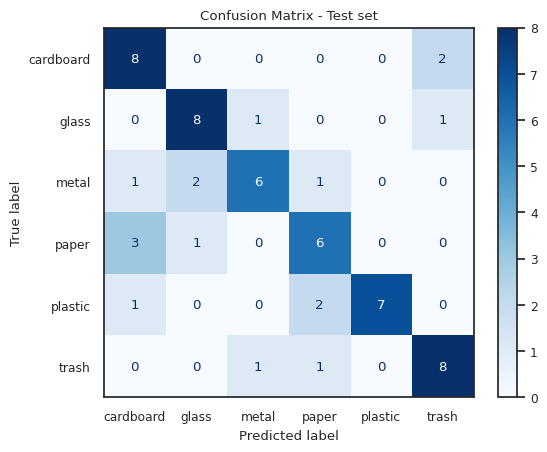

Clase 0: TP=8, FP=5, FN=2, TN=45
Clase 1: TP=8, FP=3, FN=2, TN=47
Clase 2: TP=6, FP=2, FN=4, TN=48
Clase 3: TP=6, FP=4, FN=4, TN=46
Clase 4: TP=7, FP=0, FN=3, TN=50
Clase 5: TP=8, FP=3, FN=2, TN=47


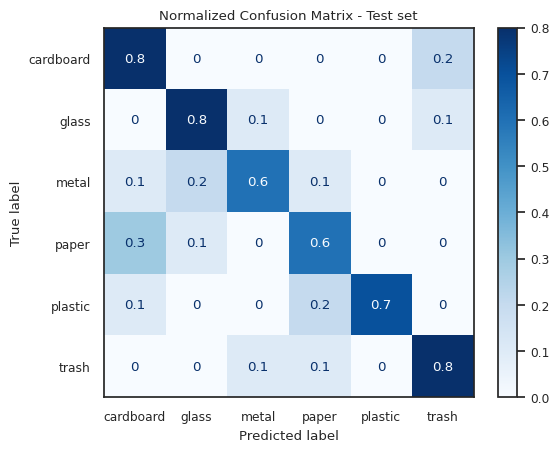

In [49]:
sns.set_theme(style="white", font_scale=0.8)

num_classes = data_module.num_classes

# ================================
# Confussion Matrix - Test set
# ================================
cm = confusion_matrix(all_labels_test, all_preds_test, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(cfg.CLASS_NAMES))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test set")
plt.savefig(f"{PERFORMANCE_FIGS_PATH}confussion_mat_test.pdf", dpi = 80)
plt.show()

# ================================
# TP, FP, FN, TN per class
# ================================
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

for i in range(num_classes):
    print(f"Clase {i}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, TN={TN[i]}")

# ================================
# Normalized Confussion Matrix
# ================================
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=(cfg.CLASS_NAMES))
disp_norm.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix - Test set")
plt.savefig(f"{PERFORMANCE_FIGS_PATH}confussion_mat_test_norm.pdf", dpi = 80)
plt.show()

../data/raw/sample_dataset/cardboard/cardboard_01395.jpg
../data/raw/sample_dataset/trash/trash_14561.jpg
../data/raw/sample_dataset/metal/metal_00091.jpg
../data/raw/sample_dataset/metal/metal_01797.jpg
../data/raw/sample_dataset/trash/trash_11003.jpg


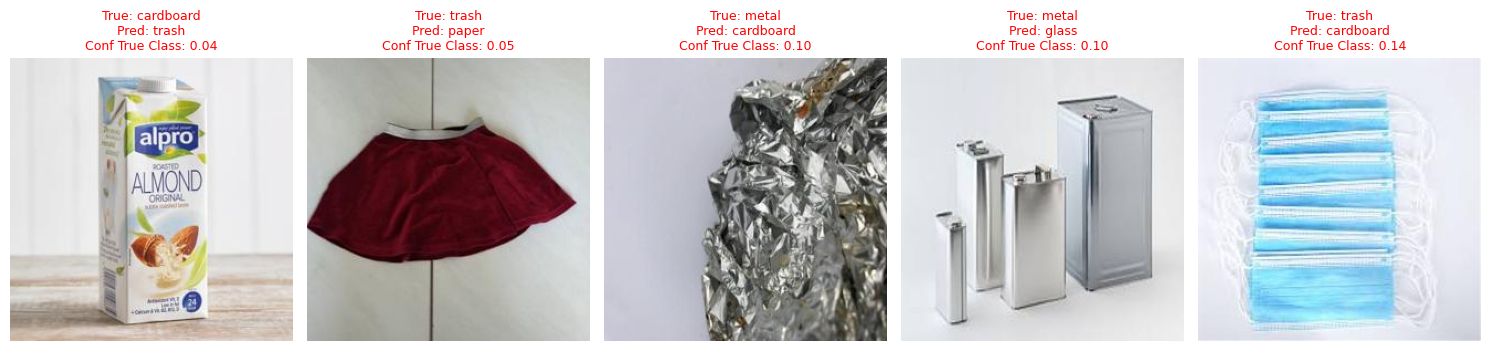

In [50]:
plot_top_misclassified(df_test_set, all_labels_test, all_preds_test, all_probs_test, DATASET_PATH, N=5, filename = "worst_classified_test_samples")

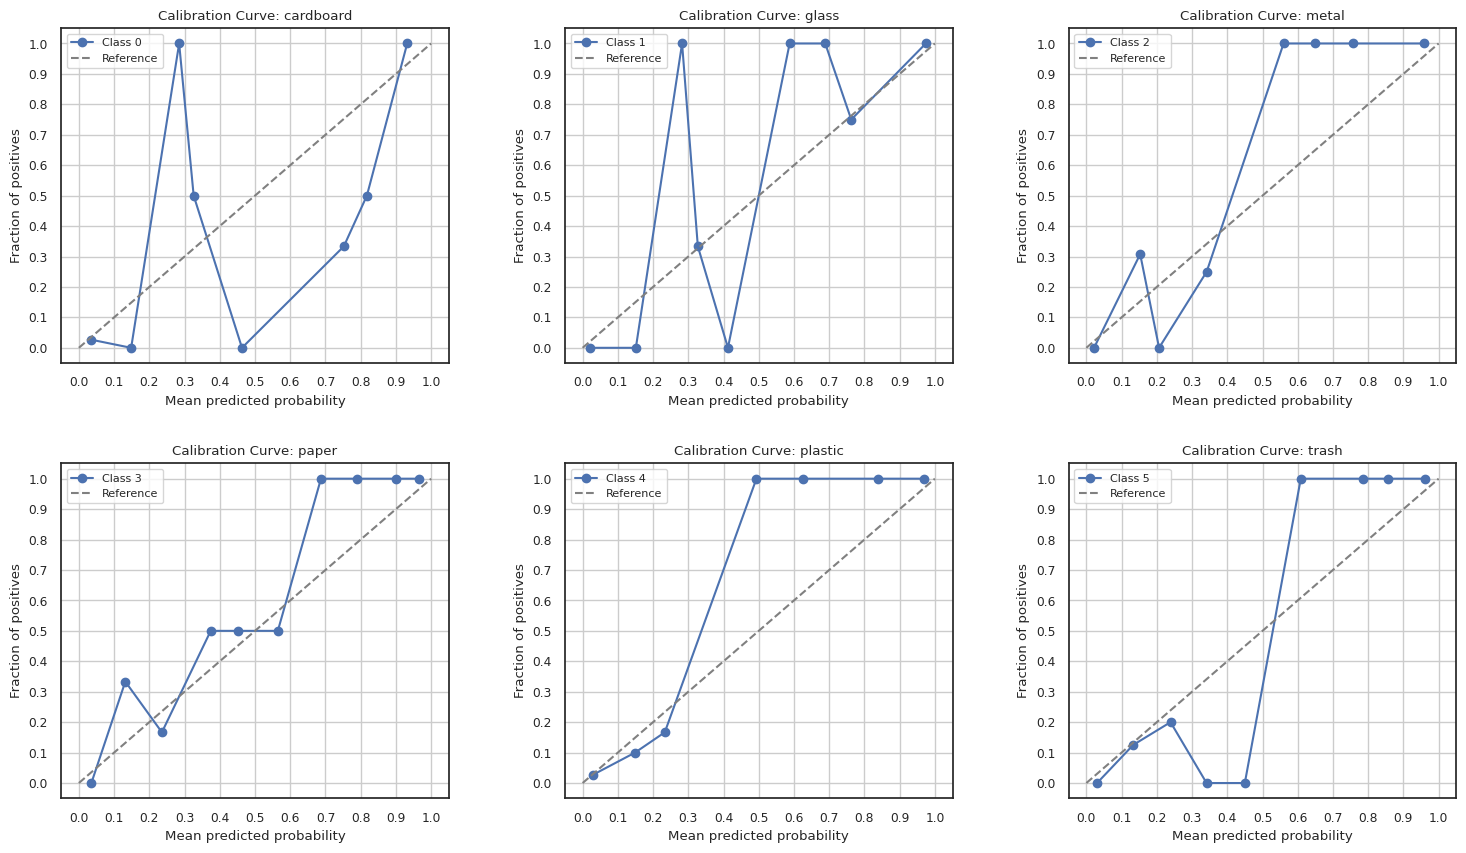

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.calibration import calibration_curve
import numpy as np

# Assuming you have:
# all_labels_test: array/tensor of true labels
# all_probs_test: array/tensor of predicted probabilities (n_samples x n_classes)
# cfg.CLASS_NAMES: list of class names
# num_classes: number of classes (6 for a 2x3 grid)

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.3)

for c in range(num_classes):
    ax = fig.add_subplot(gs[c // 3, c % 3])
    
    # Binarize y_true for this class: 1 if sample belongs to class c, else 0
    y_true_test = (all_labels_test.numpy() == c).astype(int)
    y_prob_test = all_probs_test[:, c]
    
    # Compute calibration curve
    frac_pos_test, mean_pred_test = calibration_curve(
        y_true_test, y_prob_test, n_bins=10, strategy='uniform'
    )
    
    # Plot calibration curve
    ax.plot(mean_pred_test, frac_pos_test, marker='o', label=f'Class {c}')
    
    # Plot reference line y=x
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Reference')
    
    # Axis labels, title, ticks, limits
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(f"Calibration Curve: {cfg.CLASS_NAMES[c]}")
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True)
    ax.legend(fontsize=8)
# plt.suptitle('Calibration Curves For Each Class')
plt.savefig(f"{PERFORMANCE_FIGS_PATH}calibration_curves.pdf", dpi = 80)
plt.show()
